# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [100]:
# Add any additional import statements you need here
import glob
import string
from nltk.tokenize import word_tokenize


import nltk
#nltk.download('punkt')

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "C:/Users/hunte/OneDrive/School/SanDiego/Courses/Text/TextMining_HBlum/data/" # change to your location if it is not in the same directory as your notebook

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# read in the lyrics here
# Read in the lyrics data
# Get the filepaths for our artists
artists = ["beatles", "ledzeppelin"]
lyrics_filepaths = []
artist_list = []

for i in artists:

    # Create the file path for each artist
    path = data_location + lyrics_folder + i

    # Get the files
    txt_files = glob.glob(os.path.normpath(os.path.join(path, "*.txt")))

    # Create artist list we'll need for df
    temp_list = [i] * len(txt_files)
    artist_list = artist_list + temp_list

    # Join the filepaths from different artists
    lyrics_filepaths = lyrics_filepaths + txt_files

    


lyrics_list = []
song_list = []


for file in lyrics_filepaths:

    # Get the song title
    file_temp = open(file, "r")
    title = file_temp.readline().rstrip()
    song_list.append(title)

    # Get the lyrics
    list = file_temp.readlines()[1:]
    lyrics = "".join(list)
    lyrics = lyrics.replace('\n', " ")
    lyrics_list.append(lyrics)
    file_temp.close()

# Convert to df
dict = {'artist': artist_list, 'song': song_list, 'lyrics': lyrics_list}
lyrics_data = pd.DataFrame(dict)

lyrics_data.head()

,artist,song,lyrics
0,beatles,"""All I've Got To Do""","Whenever I want you around, yeah All I gott..."
1,beatles,"""All My Loving""",Close your eyes and I'll kiss you Tomorrow ...
2,beatles,"""Anna (Go To Him)""","Anna You come and ask me, girl To set you f..."
3,beatles,"""Ask Me Why""","I love you, 'cause you tell me things I wan..."
4,beatles,"""A Taste Of Honey""",A taste of honey Tasting much sweeter than ...


In [5]:
# Read in the twitter data
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [107]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Positive 
pos_df = pd.read_table(positive_words_file).iloc[33:]
pos_df = pos_df.rename(columns={pos_df.columns[0] : 'word'})
pos_df['score'] = 1

# Negative
neg_df = pd.read_table(negative_words_file).iloc[33:]
neg_df = neg_df.rename(columns={neg_df.columns[0]: 'word'})
neg_df['score'] = 1


# Tidy df
tidy_df = pd.read_table(tidy_text_file).iloc[:, 0:2]

# Calculate the scores based on sentiment column
tidy_scores = []
for i in tidy_df['sentiment']:
    if i == 'negative':
        tidy_scores.append(-1)
    else:
        tidy_scores.append(1)

# 
tidy_df['score'] = tidy_scores
tidy_df.drop(columns=['sentiment'], inplace=True)

sent_df = pd.concat([pos_df, neg_df, tidy_df], axis = 0).reset_index(drop=True)
sent_dict = sent_df.set_index('word')['score'].to_dict()

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.

Write the scoring function:

In [108]:
# Function to calculate score
def sent_score(text):
    sentiment_score = 0
    word_bag = word_tokenize(text.lower())
    for word in word_bag:
        if word in sent_dict:
            sentiment_score += sent_dict[word]
    return sentiment_score / len(word_bag)

Run our function

In [109]:
lyrics_data['Sent_score'] = lyrics_data['lyrics'].apply(sent_score)

Question 1

In [111]:
lyrics_data.groupby(by='artist')['Sent_score'].sum()

artist
beatles        1.040979
ledzeppelin    0.810352
Name: Sent_score, dtype: float64

Question 2

In [131]:
# Top and bottom three beatles
beatles_df = lyrics_data[lyrics_data['artist'] == 'beatles']
beatles_df = beatles_df.sort_values(by='Sent_score')

print('Beatles Top Three Songs\n\n', beatles_df.tail(3)[['song', 'Sent_score']])
print(beatles_df.tail(3)['lyrics'].values)

print('\n\nBeatles Bottom Three Songs\n\n', beatles_df.head(3)[['song', 'Sent_score']])
print(beatles_df.head(3)['lyrics'].values)

Beatles Top Three Songs

                     song  Sent_score
18  "Till There Was You"    0.097015
7               "Chains"    0.102439
13          "Love Me Do"    0.267717
['   There were bells on a hill But I never heard them ringing No, I never heard them at all Till there was you  There were birds in the sky But I never saw them winging No, I never saw them at all Till there was you  Then there was music and wonderful roses They tell me in sweet fragrant meadows Of dawn and dew  There was love all around But I never heard it singing No, I never heard it at all Till there was you  Then there was music and wonderful roses They tell me in sweet fragrant meadows Of dawn and dew  There was love all around But I never heard it singing No, I never heard it at all Till there was you Till there was you '
 "   Chains, my baby's got me locked up in chains And they ain't the kind that you can see Whoa, oh, these chains of love got a hold on me, yeah  Chains, well I can't break away from these

Question 3

In [134]:
# Top and bottom three beatles
led_df = lyrics_data[lyrics_data['artist'] == 'ledzeppelin']
led_df = led_df.sort_values(by='Sent_score')

print('Led Zeppelin Top Three Songs\n\n', led_df.tail(3)[['song', 'Sent_score']])
print(led_df.tail(3)['lyrics'].values)

print('\n\Led Zeppelin Bottom Three Songs\n\n', led_df.head(3)[['song', 'Sent_score']])
print(beatles_df.head(3)['lyrics'].values)

Led Zeppelin Top Three Songs

                                          song  Sent_score
31  "Living Loving Maid (She's Just A Woman)"    0.068548
22                          "Celebration Day"    0.069231
37                         "Whole Lotta Love"    0.136719
["   With a purple umbrella and a fifty cent hat Living, loving, she's just a woman Missus cool rides out in her aged Cadillac Living, loving, she's just a woman  Come on, babe on the roundabout Ride on the merry-go-round We all know what your name is So you better lay your money down  Alimony, alimony, paying your bills Living, loving, she's just a woman When your conscience hits, you knock it back with pills Living, loving, she's just a woman  Come on, babe on the roundabout Ride on the merry-go-round We all know what your name is So you better lay your money down  Telling tall tales of how it used to be Living, loving, she's just a woman With the butler and the maid and the servants three Living, loving, she's just a woman  

Question 4

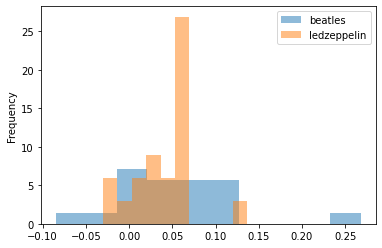

In [138]:
lyrics_data.groupby('artist')['Sent_score'].plot(kind="hist",density=True,alpha=0.5,legend=True);

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: <!-- Your answer here -->

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: <!-- Your answer here -->

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: <!-- Your answer here -->

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [ ]:
# your code here

Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 

